## Emergency Vehicle Detection CNN Model

## Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image

import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


## Step 1: Load and Preprocess Data

In [2]:
# Load CSVs
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

# Convert labels to string for 'binary' mode
train_df['emergency_or_not'] = train_df['emergency_or_not'].astype(str)

# Paths
train_dir = 'train_images'
test_dir = 'test_images'

# Parameters
IMG_SIZE = 128
BATCH_SIZE = 32


## Step 2: Image Data Generators

In [3]:

# Load CSV
train_df = pd.read_csv('train.csv')
train_df['image_names'] = train_df['image_names'].str.strip()
train_df['emergency_or_not'] = train_df['emergency_or_not'].astype(str)

# Set image parameters
IMG_SIZE = 128
BATCH_SIZE = 32

# ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Training generator
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory='train',  # Make sure this is correct
    x_col='image_names',
    y_col='emergency_or_not',
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode='binary',
    batch_size=BATCH_SIZE,
    subset='training',
    shuffle=True,
    validate_filenames=True
)

# Validation generator
val_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory='train',
    x_col='image_names',
    y_col='emergency_or_not',
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode='binary',
    batch_size=BATCH_SIZE,
    subset='validation',
    shuffle=True,
    validate_filenames=True
)


Found 1317 validated image filenames belonging to 2 classes.
Found 329 validated image filenames belonging to 2 classes.


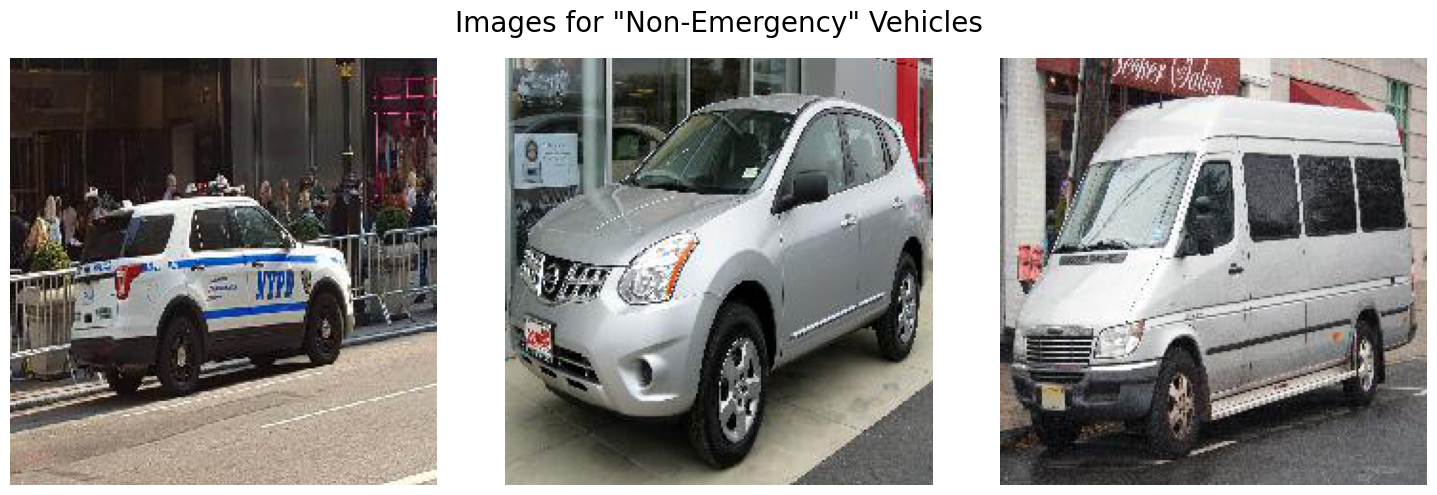

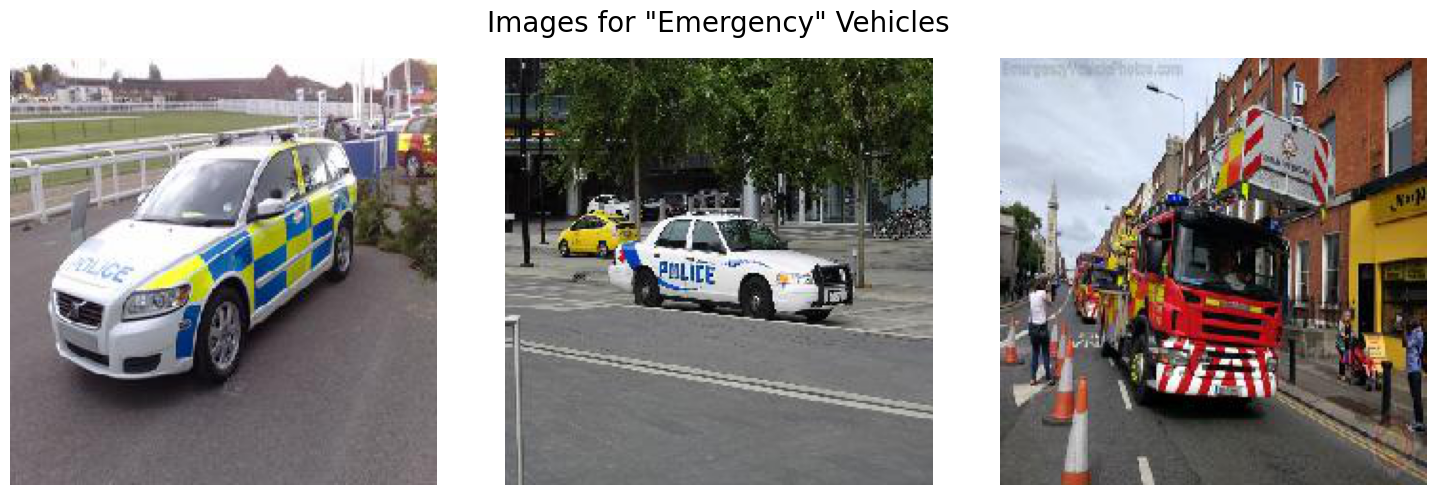

In [11]:

# Load training data
train_df = pd.read_csv('train.csv')

# Set image directory
image_dir = 'train'

# Create label mapping
label_map = {0: 'Non-Emergency', 1: 'Emergency'}

# Loop over both classes (0 and 1)
for label in train_df['emergency_or_not'].unique():
    subset = train_df[train_df['emergency_or_not'] == label]
    images = subset['image_names'].values

    # Create a figure to show 3 random images
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f'Images for "{label_map[label]}" Vehicles', fontsize=20)

    for i in range(3):
        # Pick a random image
        random_img = np.random.choice(images)
        img_path = os.path.join(image_dir, random_img)

        try:
            img = Image.open(img_path)
            ax[i].imshow(img)
            ax[i].axis('off')
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            ax[i].set_title('Error loading image')
            ax[i].axis('off')

    plt.tight_layout()
    plt.show()

## Step 3: Build CNN Model

In [4]:
model = Sequential([
    Input(shape=(128, 128, 3)),  # Use Input() here
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,392,449 (28.20 MB)

 Trainable params: 7,392,449 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

## Step 4: Train the Model

In [5]:
model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator)
)

c:\ProgramData\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 33s 722ms/step - accuracy: 0.5550 - loss: 0.7097 - val_accuracy: 0.7173 - val_loss: 0.5869
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 222ms/step - accuracy: 0.7399 - loss: 0.5651 - val_accuracy: 0.7204 - val_loss: 0.5546
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 234ms/step - accuracy: 0.7646 - loss: 0.5069 - val_accuracy: 0.7903 - val_loss: 0.4841
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 233ms/step - accuracy: 0.7929 - loss: 0.4597 - val_accuracy: 0.7872 - val_loss: 0.4684
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 239ms/step - accuracy: 0.8156 - loss: 0.4315 - val_accuracy: 0.7508 - val_loss: 0.5070
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 236ms/step - accuracy: 0.8430 - loss: 0.3923 - val_accuracy: 0.7964 - val_loss: 0.4525
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 235ms/step - accuracy: 0.8595 - loss: 0.3555 - val_accuracy: 0.8024 - val_loss: 0.4441
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 234ms/step - accuracy: 0.8576 - loss: 0.3499 - val_accur

In [10]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)

Epoch 1/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 11s 255ms/step - accuracy: 0.8940 - loss: 0.2773 - val_accuracy: 0.7812 - val_loss: 0.4539
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 223ms/step - accuracy: 0.9049 - loss: 0.2645 - val_accuracy: 0.7994 - val_loss: 0.4417
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 215ms/step - accuracy: 0.9095 - loss: 0.2456 - val_accuracy: 0.7964 - val_loss: 0.4371
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 217ms/step - accuracy: 0.9298 - loss: 0.2185 - val_accuracy: 0.7842 - val_loss: 0.4493
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 231ms/step - accuracy: 0.9264 - loss: 0.2117 - val_accuracy: 0.7872 - val_loss: 0.4430
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 232ms/step - accuracy: 0.9484 - loss: 0.1816 - val_accuracy: 0.7812 - val_loss: 0.4488
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 232ms/step - accuracy: 0.9356 - loss: 0.1851 - val_accuracy: 0.7842 - val_loss: 0.4642
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 235ms/step - accuracy: 0.9571 - loss: 0.1600 - val_accura

## Step 5: Plot Accuracy and Loss

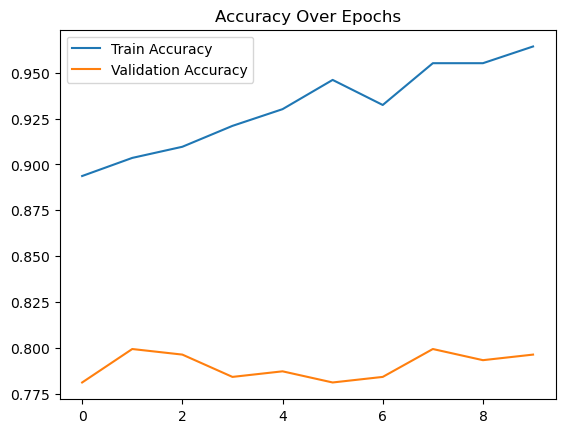

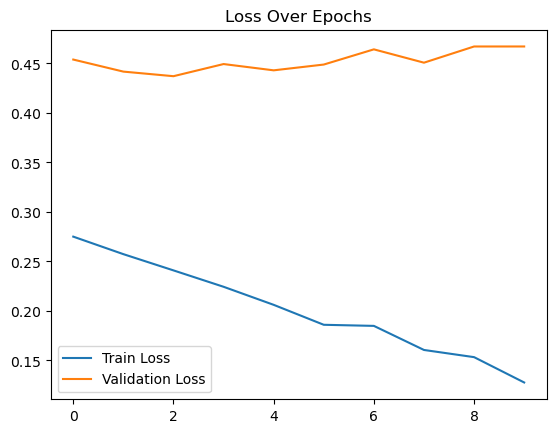

In [11]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Accuracy Over Epochs")
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Loss Over Epochs")
plt.legend()
plt.show()


## Step 6: Evaluate with Confusion Matrix

11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 166ms/step


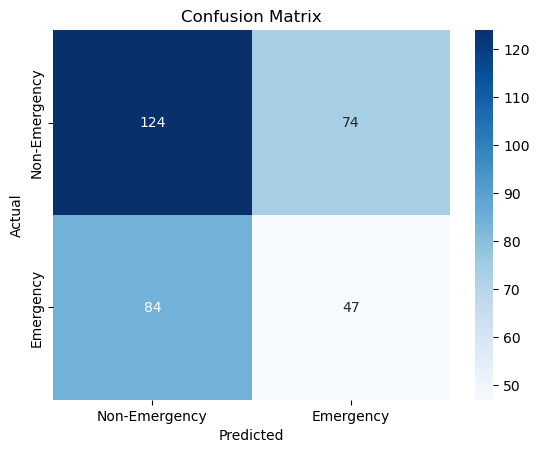

               precision    recall  f1-score   support

Non-Emergency       0.60      0.63      0.61       198
    Emergency       0.39      0.36      0.37       131

     accuracy                           0.52       329
    macro avg       0.49      0.49      0.49       329
 weighted avg       0.51      0.52      0.52       329



In [ ]:
# Predict on validation set
val_generator.reset()
preds = model.predict(val_generator, verbose=1)
pred_labels = (preds > 0.5).astype(int).reshape(-1)

true_labels = val_generator.classes

# Confusion matrix
cm = confusion_matrix(true_labels, pred_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Emergency', 'Emergency'], yticklabels=['Non-Emergency', 'Emergency'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(true_labels, pred_labels, target_names=['Non-Emergency', 'Emergency']))

## Step 7: Predict on Test Set and Save Results

In [ ]:
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory='test',
    x_col='image_names',
    y_col=None,
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode=None,
    batch_size=BATCH_SIZE,
    shuffle=False
)

# Now predict
predictions = model.predict(test_generator, verbose=1)



Found 706 validated image filenames.


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step


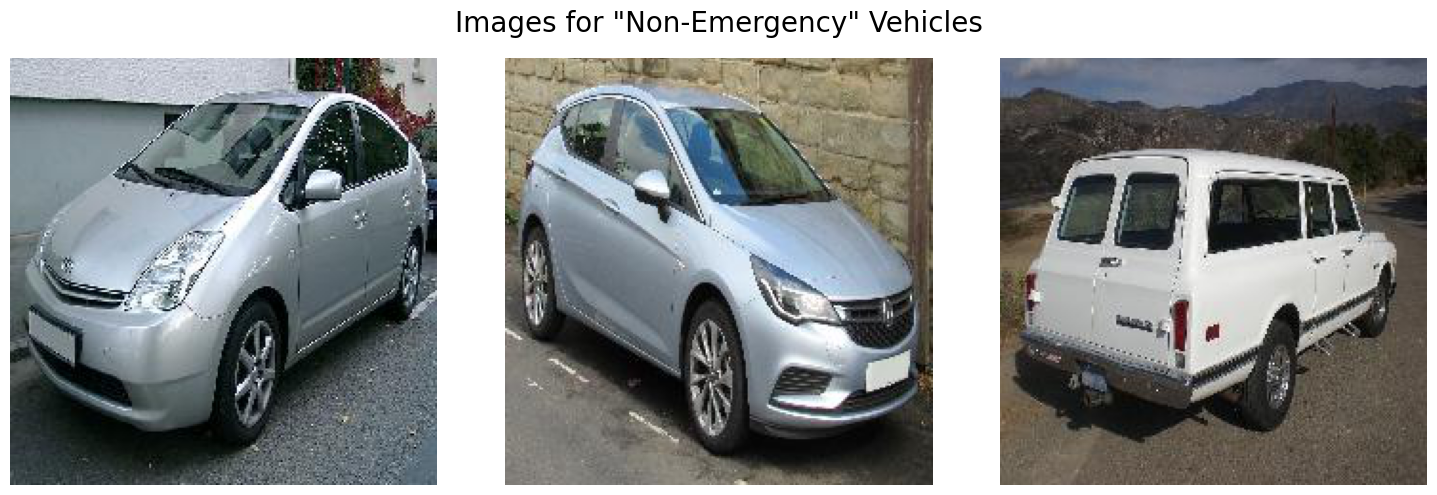

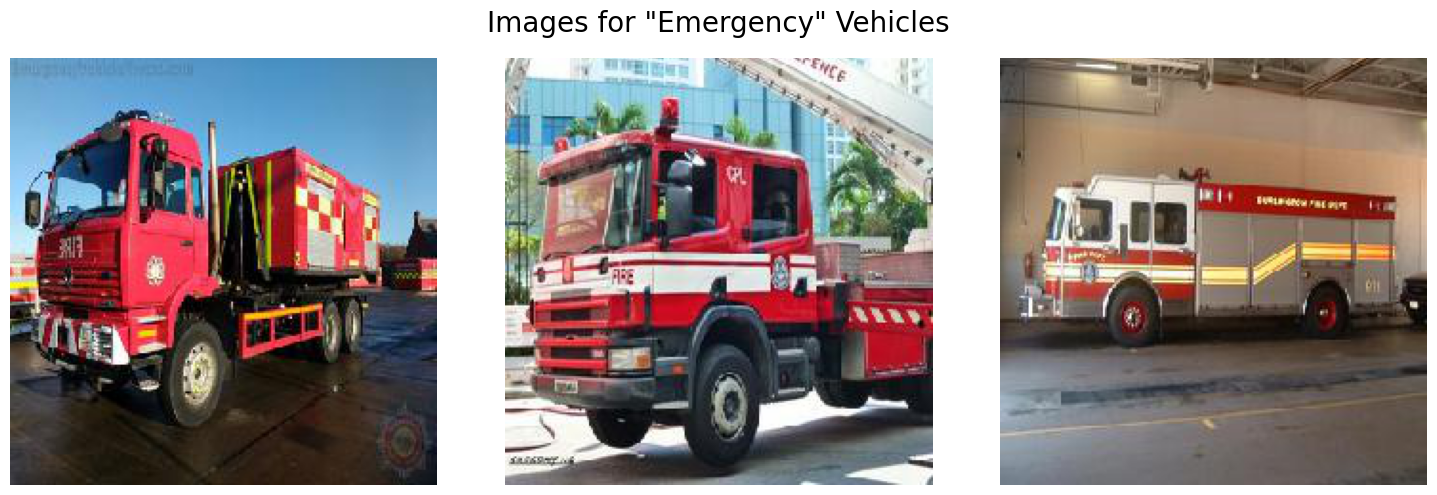

In [12]:
model.save("emergency_vehicle_cnn.h5")